#Analysis for Scraping

#Imports

In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer, VectorAssembler, IndexToString, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
from pyspark.sql.functions import col, udf, when, lit, to_json, trim, element_at, split, regexp_extract, create_map, from_json, explode, sum as _sum, count, levenshtein
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from json.decoder import JSONDecodeError
from pyspark.sql.types import StringType
import re
from pyspark.sql import Window

#Data Analysis

In [0]:
# Initializing Spark Session
spark = SparkSession.builder.getOrCreate()

##Kaggle Dataset

In [0]:
# Reading the dataset
jobs_in_data = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/sewar.hino@campus.technion.ac.il/jobs_in_data.csv")

In [0]:
data_jobs_df = jobs_in_data.toPandas()

# Drop the 'salary' column from the DataFrame - to use concistent USD
data_jobs_df.drop(columns=['salary'], inplace=True)

# Convert 'salary' column from string to int
data_jobs_df['salary_in_usd'] = data_jobs_df['salary_in_usd'].astype(int)

data_jobs_df

,work_year,job_title,job_category,salary_currency,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,company_location,company_size
0,2023,Data DevOps Engineer,Data Engineering,EUR,95012,Germany,Mid-level,Full-time,Hybrid,Germany,L
1,2023,Data Architect,Data Architecture and Modeling,USD,186000,United States,Senior,Full-time,In-person,United States,M
2,2023,Data Architect,Data Architecture and Modeling,USD,81800,United States,Senior,Full-time,In-person,United States,M
3,2023,Data Scientist,Data Science and Research,USD,212000,United States,Senior,Full-time,In-person,United States,M
4,2023,Data Scientist,Data Science and Research,USD,93300,United States,Senior,Full-time,In-person,United States,M
...,...,...,...,...,...,...,...,...,...,...,...
9350,2021,Data Specialist,Data Management and Strategy,USD,165000,United States,Senior,Full-time,Remote,United States,L
9351,2020,Data Scientist,Data Science and Research,USD,412000,United States,Senior,Full-time,Remote,United States,L
9352,2021,Principal Data Scientist,Data Science and Research,USD,151000,United States,Mid-level,Full-time,Remote,United States,L
9353,2020,Data Scientist,Data Science and Research,USD,105000,United States,Entry-level,Full-time,Remote,United States,S


###Numerical Data

In [0]:
# Assuming 'data_jobs_df' is your DataFrame
numerical_variables = data_jobs_df.select_dtypes(include=['int64', 'float64'])

# Data Description
data_description = data_jobs_df.describe()

# Display data description
print("Data Description:")
print(data_description)

# Missing Data Checks for Numerical Columns (int64 and float64)
missing_data_summary = pd.DataFrame(numerical_variables.isnull().sum(), columns=['Missing Values'])
missing_data_summary['Percentage'] = (missing_data_summary['Missing Values'] / len(numerical_variables)) * 100

# Display missing data summary for numerical columns
print("\nMissing Data Summary for Numerical Columns:")
print(missing_data_summary)


Data Description:
       salary_in_usd
count    9355.000000
mean   150299.495564
std     63177.372024
min     15000.000000
25%    105700.000000
50%    143000.000000
75%    186723.000000
max    450000.000000

Missing Data Summary for Numerical Columns:
               Missing Values  Percentage
salary_in_usd               0         0.0


No missing values in the salary column

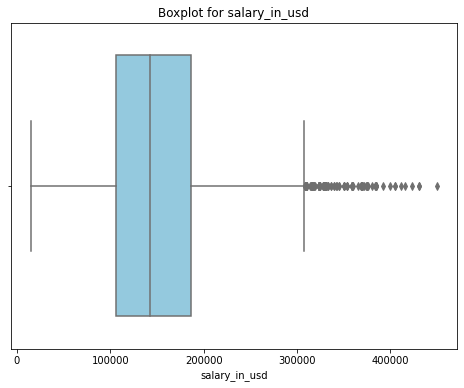


Summary Table of Potential Outliers:
        Variable Potential Outliers  Percentage of Total
0  salary_in_usd                158             1.688936


In [0]:
# Outlier Detection
outliers_summary = pd.DataFrame(columns=['Variable', 'Potential Outliers', 'Percentage of Total'])

for column in numerical_variables.columns:
    # Display boxplot for each numerical variable
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data_jobs_df[column], color='skyblue')
    plt.title(f"Boxplot for {column}")
    plt.show()

    # Identify potential outliers using the IQR method
    Q1 = data_jobs_df[column].quantile(0.25)
    Q3 = data_jobs_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data_jobs_df[column] < lower_bound) | (data_jobs_df[column] > upper_bound)
    num_outliers = outliers.sum()
    percentage_outliers = (num_outliers / len(data_jobs_df)) * 100

    # Append information to the summary DataFrame
    outliers_summary = outliers_summary.append({
        'Variable': column,
        'Potential Outliers': num_outliers,
        'Percentage of Total': percentage_outliers
    }, ignore_index=True)

# Display summary table of potential outliers
print("\nSummary Table of Potential Outliers:")
print(outliers_summary)


The summary table indicates that the 'salary' variable has 158 potential outliers, accounting for approximately 1.69% of the total data.

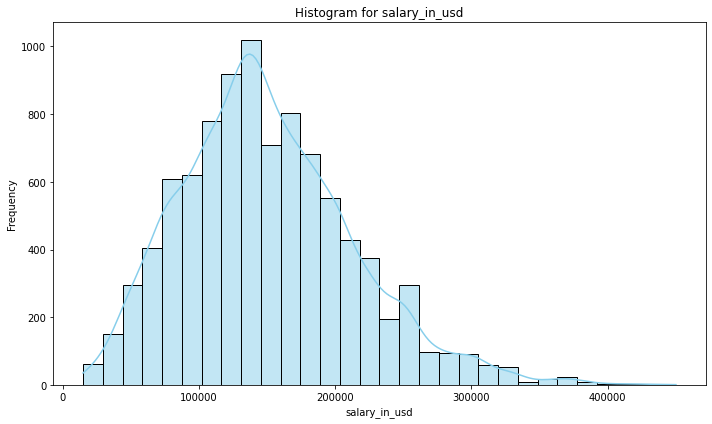

In [0]:
numerical_variables = data_jobs_df.select_dtypes(include=['int64', 'float64'])

# Set the number of bins for histograms
num_bins = 30

# Plot histograms for numerical columns
for column in numerical_variables.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data_jobs_df[column], bins=num_bins, kde=True, color='skyblue')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

The distribution of salaries resembles a normal distribution with a slight right skew.

###Categorical Data

In [0]:
# Assuming 'data_jobs_df' is your DataFrame
categorical_variables = data_jobs_df.select_dtypes(include=['object'])

# Check for missing data and calculate the percentage for each variable
for column in categorical_variables.columns:
    missing_data_percentage = (categorical_variables[column].isnull().sum() / len(categorical_variables[column])) * 100
    print(f"\nMissing Data Percentage for {column}: {missing_data_percentage:.2f}%\n")

    # Check for unusual data (e.g., check unique values and their counts)
    unique_values = categorical_variables[column].unique()
    if len(unique_values) < 10:
        print(f"Unique values for {column}:\n{unique_values}\n")
    else:
        print(f"Number of unique values for {column}: {len(unique_values)}\n")

        # Print the top 5 values and their counts for larger sets
        top_values_counts = categorical_variables[column].value_counts().head()
        print(f"Top 5 values and their counts for {column}:\n{top_values_counts}\n")

# Handle missing data (impute or drop)
# For demonstration purposes, you might want to choose a more appropriate strategy based on your data
categorical_variables.fillna('Unknown', inplace=True)



Missing Data Percentage for work_year: 0.00%

Unique values for work_year:
['2023' '2022' '2020' '2021']


Missing Data Percentage for job_title: 0.00%

Number of unique values for job_title: 125

Top 5 values and their counts for job_title:
Data Engineer                2195
Data Scientist               1989
Data Analyst                 1388
Machine Learning Engineer     991
Applied Scientist             272
Name: job_title, dtype: int64


Missing Data Percentage for job_category: 0.00%

Number of unique values for job_category: 10

Top 5 values and their counts for job_category:
Data Science and Research    3014
Data Engineering             2260
Data Analysis                1457
Machine Learning and AI      1428
Leadership and Management     503
Name: job_category, dtype: int64


Missing Data Percentage for salary_currency: 0.00%

Number of unique values for salary_currency: 11

Top 5 values and their counts for salary_currency:
USD    8591
GBP     347
EUR     340
CAD      38
AUD    

work_year:
* There are no missing values in the 'work_year' column.
* All the available values represent years between 2020 and 2023.

job_title:
* There are no missing values in the 'job_title' column.
* There are 125 unique job titles.
* The top 5 most common job titles are 'Data Engineer', 'Data Scientist', 'Data Analyst', 'Machine Learning Engineer', and 'Applied Scientist'.

job_category:
* There are no missing values in the 'job_category' column.
* There are 10 unique job categories.
* The top 5 most common job categories are 'Data Science and Research', 'Data Engineering', 'Data Analysis', 'Machine Learning and AI', and 'Leadership and Management'.

salary_currency:
* There are no missing values in the 'salary_currency' column.
* There are 11 unique salary currencies.
* The majority of salaries are in USD, followed by GBP, EUR, CAD, and AUD.

employee_residence:
* There are no missing values in the 'employee_residence' column.
* There are 83 unique residence locations.
* The top 5 most common residence locations are the United States, United Kingdom, Canada, Spain, and Germany.

experience_level:
* There are no missing values in the 'experience_level' column.
* There are 4 unique experience levels: 'Mid-level', 'Senior', 'Executive', and 'Entry-level'.

employment_type:
* There are no missing values in the 'employment_type' column.
* There are 4 unique employment types: 'Full-time', 'Part-time', 'Contract', and 'Freelance'.

work_setting:
* There are no missing values in the 'work_setting' column.
* There are 3 unique work settings: 'Hybrid', 'In-person', and 'Remote'.

company_location:
* There are no missing values in the 'company_location' column.
* There are 70 unique company locations.
* The top 5 most common company locations are the United States, United Kingdom, Canada, Spain, and Germany.

company_size:
* There are no missing values in the 'company_size' column.
* There are 3 unique company sizes: 'L' (Large), 'M' (Medium), and 'S' (Small).

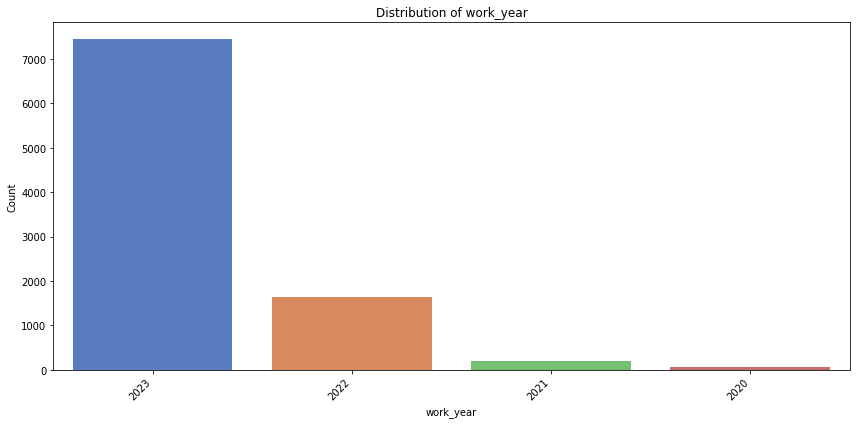

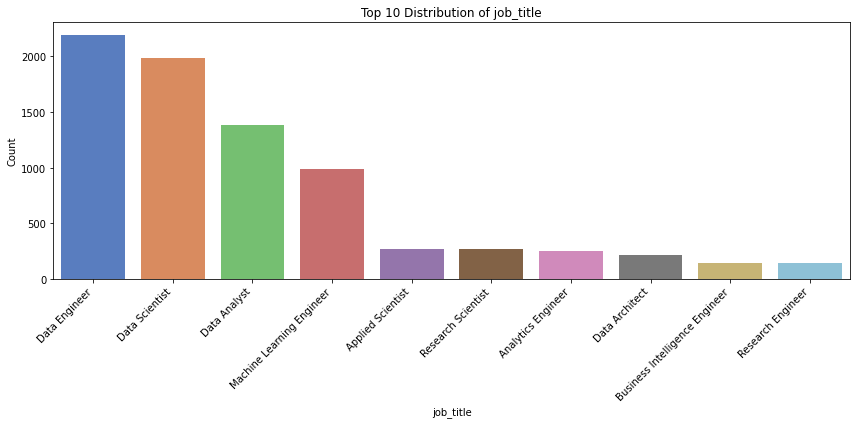

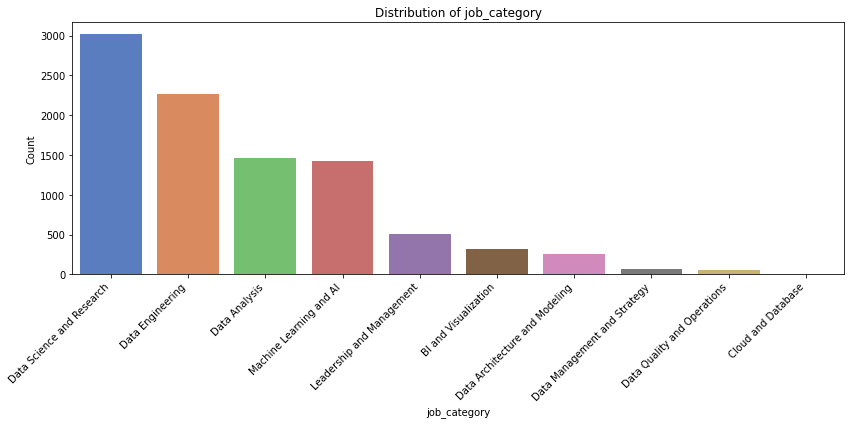

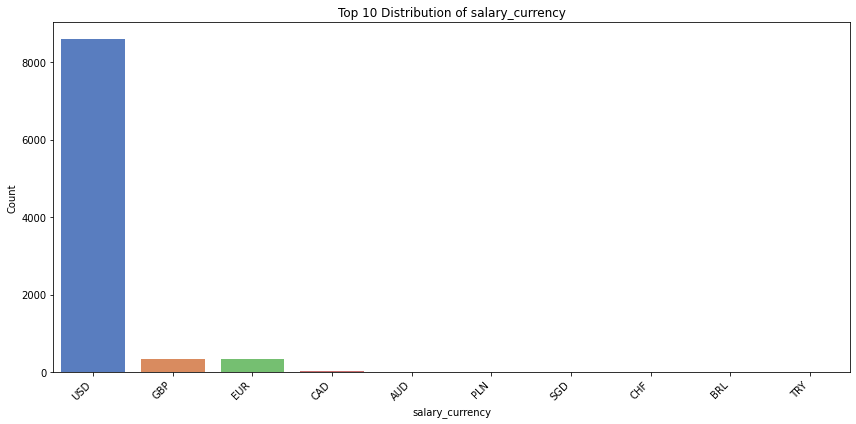

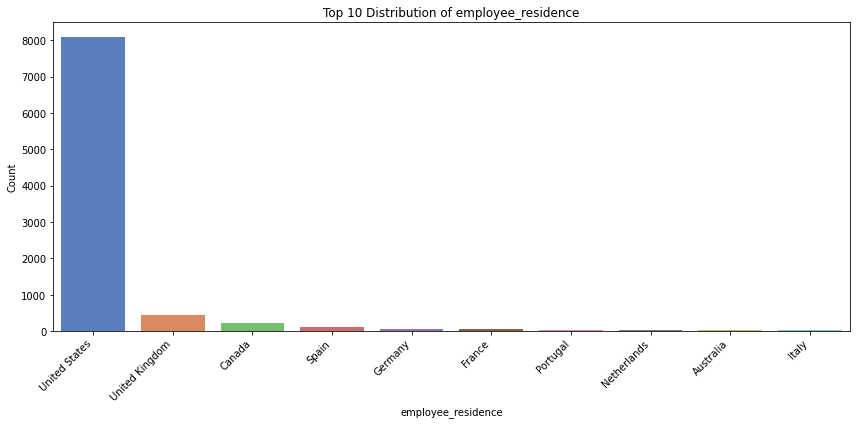

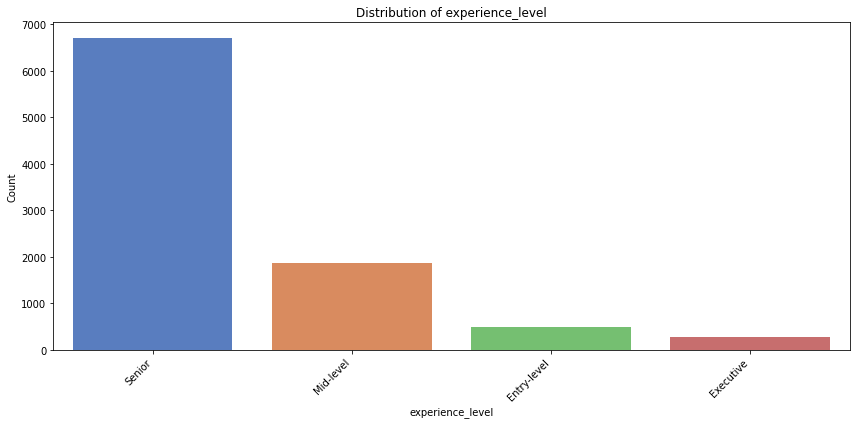

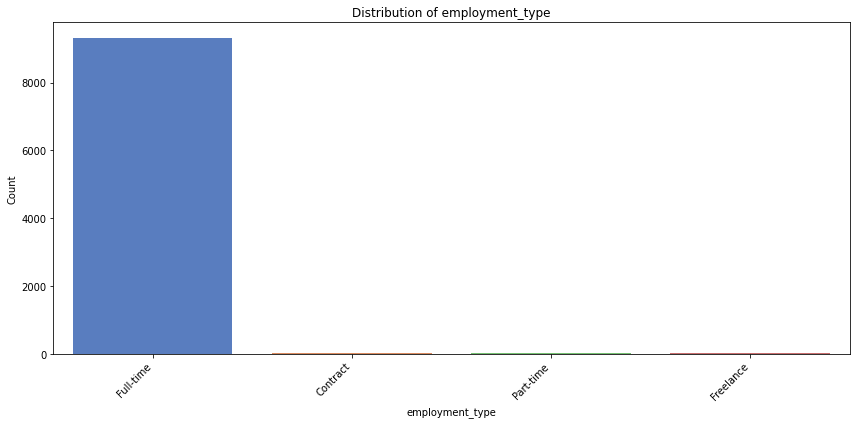

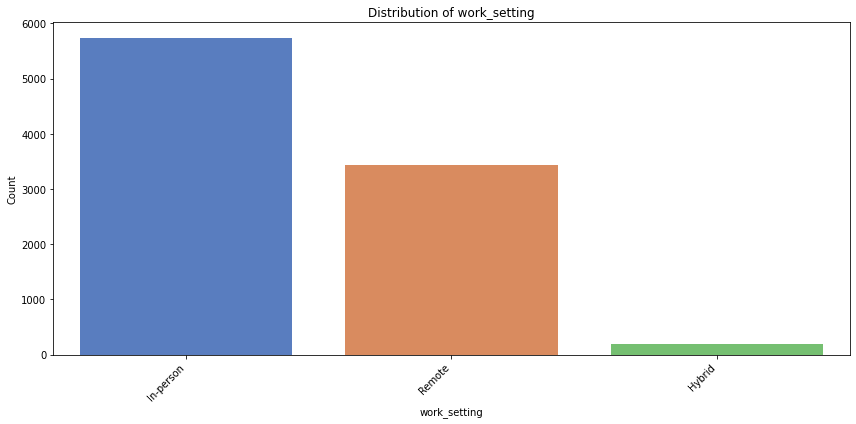

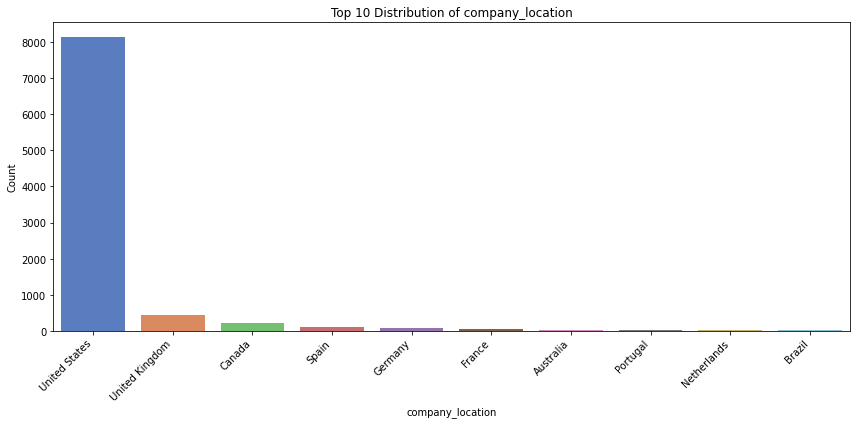

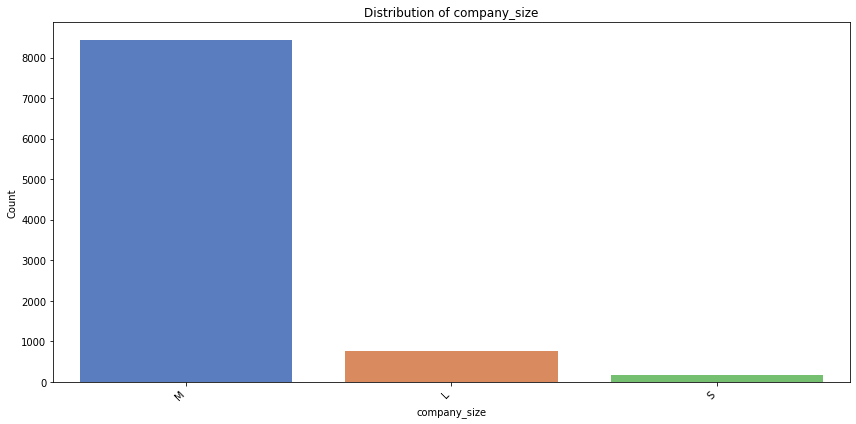

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with 'Unknown' values
categorical_variables = categorical_variables[~categorical_variables.isin(['Unknown']).any(axis=1)].dropna()

# Define a custom color palette
custom_palette = sns.color_palette('muted')  # You can choose any other palette

for column in categorical_variables.columns:
    # Check the number of unique values in the column
    unique_values_count = len(categorical_variables[column].unique())
    
    if unique_values_count > 10:
        # Select the top 10 most common values
        top_values = categorical_variables[column].value_counts().head(10)
        
        # Bar chart for the top 10 values
        plt.figure(figsize=(12, 6))
        sns.countplot(x=column, data=data_jobs_df[data_jobs_df[column].isin(top_values.index)], 
                      order=top_values.index, palette=custom_palette)
        plt.title(f'Top 10 Distribution of {column}')
    else:
        # Bar chart for all values if unique values are less than or equal to 10
        plt.figure(figsize=(12, 6))
        sns.countplot(x=column, data=data_jobs_df, 
                      order=data_jobs_df[column].value_counts().index, palette=custom_palette)
        plt.title(f'Distribution of {column}')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation angle and alignment
    plt.tight_layout()  # Ensure tight layout to prevent clipping
    plt.show()


###ML-Oriented Analysis

We aim to explore how salary values vary across different categories represented by columns used for prediction: job title, experience level, employee residence, and company size.

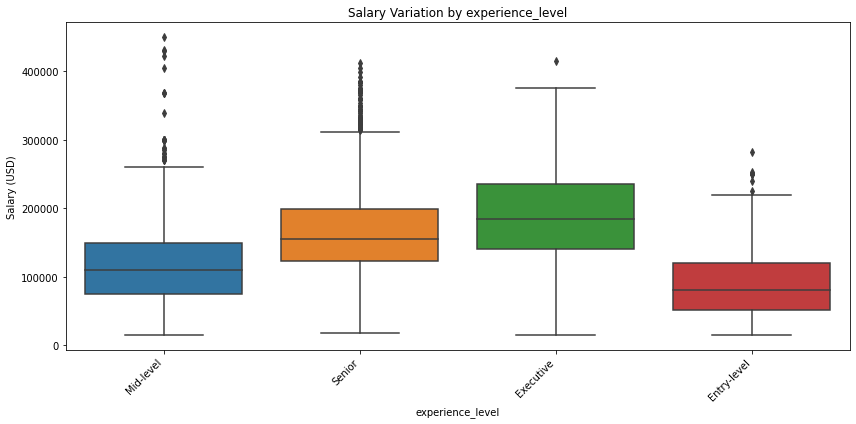

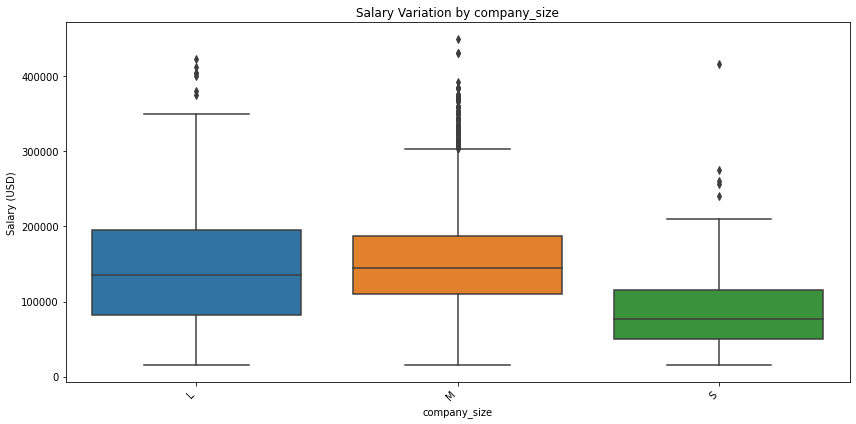

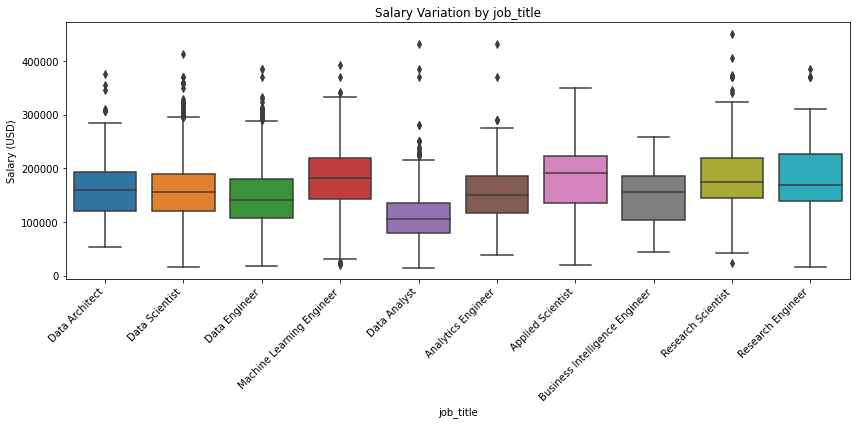

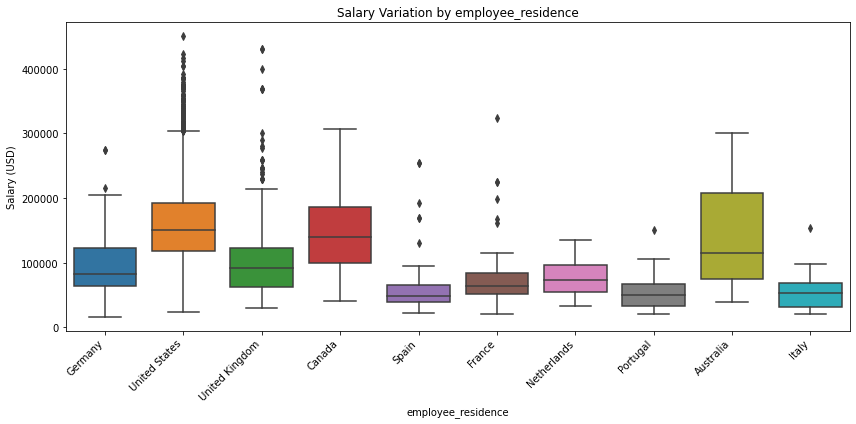


Numerical Summary for experience_level:
                   count           mean           std      min       25%  \
experience_level                                                           
Entry-level        496.0   88534.776210  49102.124930  15000.0   51726.0   
Executive          281.0  189462.914591  68792.976980  15000.0  140000.0   
Mid-level         1869.0  117523.918138  55453.622208  15000.0   75000.0   
Senior            6709.0  162356.126099  59523.013825  18381.0  122600.0   

                       50%       75%       max  
experience_level                                
Entry-level        80000.0  120000.0  281700.0  
Executive         185000.0  235000.0  416000.0  
Mid-level         110000.0  149600.0  450000.0  
Senior            155000.0  198800.0  412000.0  

Numerical Summary for company_size:
               count           mean           std      min       25%  \
company_size                                                           
L              748.0  14109

In [0]:
# Get the top 10 most common values for job_title and employee_residence
top_job_titles = data_jobs_df['job_title'].value_counts().head(10).index.tolist()
top_employee_residences = data_jobs_df['employee_residence'].value_counts().head(10).index.tolist()

# Define the columns for analysis
columns_of_interest = ['experience_level', 'company_size']

# Add job_title and employee_residence if they are in columns_of_interest
if 'job_title' not in columns_of_interest:
    columns_of_interest.append('job_title')
if 'employee_residence' not in columns_of_interest:
    columns_of_interest.append('employee_residence')

# Create boxplots for each column
for column in columns_of_interest:
    plt.figure(figsize=(12, 6))
    if column == 'job_title':
        sns.boxplot(x=column, y='salary_in_usd', data=data_jobs_df[data_jobs_df[column].isin(top_job_titles)])
    elif column == 'employee_residence':
        sns.boxplot(x=column, y='salary_in_usd', data=data_jobs_df[data_jobs_df[column].isin(top_employee_residences)])
    else:
        sns.boxplot(x=column, y='salary_in_usd', data=data_jobs_df)
    plt.title(f'Salary Variation by {column}')
    plt.xlabel(column)
    plt.ylabel('Salary (USD)')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()

# Print numerical results
for column in columns_of_interest:
    print(f"\nNumerical Summary for {column}:")
    if column == 'job_title':
        print(data_jobs_df[data_jobs_df[column].isin(top_job_titles)].groupby(column)['salary_in_usd'].describe())
    elif column == 'employee_residence':
        print(data_jobs_df[data_jobs_df[column].isin(top_employee_residences)].groupby(column)['salary_in_usd'].describe())
    else:
        print(data_jobs_df.groupby(column)['salary_in_usd'].describe())


The numerical summaries and respective boxplots offer a comprehensive view of how salaries reflect across different categories relevant to the machine learning task:

**Experience Level:**

- Salary distribution varies significantly across different experience levels. Entry-level positions generally have lower salaries compared to senior and executive roles, reflecting the typical salary progression within organizations.
- Executive positions exhibit the highest salary range and mean salary, suggesting higher compensation for positions with greater responsibility and seniority.

**Company Size:**

- The size of the company also influences salary distribution. Larger companies tend to offer higher average salaries compared to smaller ones, which could be attributed to larger budgets and resources available for employee compensation.
- Medium-sized companies show the highest mean salary among the categories, indicating a potential balance between financial stability and growth opportunities.

**Job Title:**

- Salaries vary considerably across different job titles, reflecting the diverse skill sets and responsibilities associated with each role.
- Data-centric roles such as 'Data Scientists', 'Applied Scientists', and 'Machine Learning Engineers' typically command higher salaries, likely due to high demand and specialized expertise required in these fields.

**Employee Residence:**

- Geographic location plays a significant role in determining salary levels, with employees in regions like the United States generally earning higher salaries compared to other countries.
- However, there is variation within countries as well, suggesting factors such as cost of living, industry demand, and local market conditions influence salary disparities.

##Linkedin Datasets - Original and Additional

At this juncture, we will examine the profiles earmarked for salary prediction through our model. To ensure consistency and coherence in our data analysis, our initial step involves feature engineering and standardization of the profiles. A boolean variable will denote whether a profile originates from the original 'linkedIn/people' dataset or from scraping operations.

In [0]:
# Load datasets
scrapped_big_companies = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/sewar.hino@campus.technion.ac.il/LinkedIn_people_profiles_BIG_COMPANIES_ONLY.csv")

job_titles = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/sewar.hino@campus.technion.ac.il/titles.csv")

companies = spark.read.parquet('/linkedin/companies')

profiles = spark.read.parquet('/linkedin/people')

extra_profiles = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/sewar.hino@campus.technion.ac.il/scrabbed_profiles.csv")

In [0]:
# preapare data sets

profiles = profiles.withColumnRenamed("current_company:company_id", "current_company_company_id")
profiles = profiles.withColumnRenamed("current_company:name", "current_company_name")
profiles = profiles.withColumnRenamed("city", "location__DUPLICATE")
columns_of_interest = ['current_company_company_id', 'id', 'position', 'about','current_company','experience','location__DUPLICATE','current_company_name', 'country_code']  


profiles1 = profiles.select(columns_of_interest) # Original data
extra_profiles1 = extra_profiles.select(columns_of_interest) # Scraped data

profiles1 = profiles1.withColumn("is_original_profile", lit(1))
extra_profiles1 = extra_profiles1.withColumn("is_original_profile", lit(0))

profiles1 = profiles1.dropDuplicates(['id'])
extra_profiles1 = extra_profiles1.dropDuplicates(['id'])

profiles1 = profiles1.withColumn("current_company", to_json("current_company"))
profiles1 = profiles1.withColumn("experience", to_json("experience"))

combined_profiles = profiles1.unionByName(extra_profiles1, allowMissingColumns=True)

###Sampling

for easier preprocessing - delete when and edit done

In [0]:
# # Sample 1000 rows randomly from combined_profiles
# sampled_profiles = combined_profiles.sample(withReplacement=False, fraction=1000/combined_profiles.count(), seed=70)


###Employee Residence

In [0]:
from pyspark.sql.functions import col, create_map, when

# Define a mapping dictionary for country codes to country names
country_code_mapping = {
    "LT": "Lithuania",
    "FI": "Finland",
    "UA": "Ukraine",
    "RO": "Romania",
    "NL": "Netherlands",
    "PL": "Poland",
    "AT": "Austria",
    "RU": "Russia",
    "HR": "Croatia",
    "CZ": "Czech Republic",
    "PT": "Portugal",
    "BY": "Belarus",
    "MD": "Moldova",
    "DE": "Germany",
    "ES": "Spain",
    "ME": "Montenegro",
    "RS": "Serbia",
    "FR": "France",
    "CH": "Switzerland",
    "GR": "Greece",
    "US": "United States"
}

# Convert the mapping dictionary to a Spark DataFrame
country_mapping_df = spark.createDataFrame(country_code_mapping.items(), ["country_code", "country_name"])

# Join the sampled DataFrame with the country mapping DataFrame to get the country names
df_with_country_names = combined_profiles.join(country_mapping_df, on="country_code", how="left")

# Use when() to handle missing values and fill them with "Unknown"
df_with_country_names = df_with_country_names.withColumn("country_name", 
                                                         when(col("country_name").isNull(), "Unknown")
                                                         .otherwise(col("country_name")))

# Extract the distinct values from the 'employee_residence' column in 'jobs_in_data'
employee_residence_values = jobs_in_data.select('employee_residence').distinct().rdd.flatMap(lambda x: x).collect()

# Filter 'df_with_country_names' based on 'country_name' being in the values list of 'employee_residence' in 'jobs_in_data'
filtered_df = df_with_country_names.filter(col('country_name').isin(employee_residence_values))

# Rename the column country_name to employee_residence
filtered_df = filtered_df.withColumnRenamed("country_name", "employee_residence")


###Jobs

In [0]:
# Rename 'id' column
filtered_df = filtered_df.withColumnRenamed("id", "profile_id")

# List of keywords related to the data domain
data_domain_keywords = ["data", "analyst", "scientist", "engineer", "machine learning", "AI", "big data"]

# Define a function to check if a profile is related to the data domain
def is_related_to_data_domain(position):
    for keyword in data_domain_keywords:
        if keyword.lower() in position.lower():
            return True
    return False

# Register the UDF
is_related_udf = udf(is_related_to_data_domain, BooleanType())

# Apply the UDF to filter out unrelated profiles
filtered_df = filtered_df.filter(is_related_udf(col("position")))

In [0]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, Tokenizer, NGram, HashingTF, MinHashLSH, RegexTokenizer, SQLTransformer
model = Pipeline(stages=[
    SQLTransformer(statement="SELECT *, lower(job_title) lower FROM __THIS__"),
    Tokenizer(inputCol="lower", outputCol="token"),
    StopWordsRemover(inputCol="token", outputCol="stop"),
    SQLTransformer(statement="SELECT *, concat_ws(' ', stop) concat FROM __THIS__"),
    RegexTokenizer(pattern="", inputCol="concat", outputCol="char", minTokenLength=1),
    NGram(n=2, inputCol="char", outputCol="ngram"),
    HashingTF(inputCol="ngram", outputCol="vector"),
    MinHashLSH(inputCol="vector", outputCol="lsh", numHashTables=3)
]).fit(jobs_in_data)

result_jobs = model.transform(jobs_in_data)
result_jobs = result_jobs.filter(F.size(F.col("ngram")) > 0)

In [0]:
model = Pipeline(stages=[
    SQLTransformer(statement="SELECT *, lower(position) lower FROM __THIS__"),
    Tokenizer(inputCol="lower", outputCol="token"),
    StopWordsRemover(inputCol="token", outputCol="stop"),
    SQLTransformer(statement="SELECT *, concat_ws(' ', stop) concat FROM __THIS__"),
    RegexTokenizer(pattern="", inputCol="concat", outputCol="char", minTokenLength=1),
    NGram(n=2, inputCol="char", outputCol="ngram"),
    HashingTF(inputCol="ngram", outputCol="vector"),
    MinHashLSH(inputCol="vector", outputCol="lsh", numHashTables=3)
]).fit(filtered_df)

result_filtered = model.transform(filtered_df)
result_filtered = result_filtered.filter(F.size(F.col("ngram")) > 0)

In [0]:
from pyspark.sql.functions import col

# Filter out rows with null values in the 'position' column
result_filtered = result_filtered.filter(col("position").isNotNull())

# Perform the similarity join operation
result = model.stages[-1].approxSimilarityJoin(result_filtered, result_jobs, 0.5, "jaccardDist")

# Select and sort the relevant columns
result = (result
          .select('datasetA.profile_id', 'datasetA.position', 'datasetB.job_title', 'jaccardDist')
          .sort(col('datasetA.position')))


In [0]:
w = Window.partitionBy('profile_id')
result = (result
           .withColumn('minDist', F.min('jaccardDist').over(w))
           .where(F.col('jaccardDist') == F.col('minDist'))
           .drop('minDist'))
(result
 .select('position', 'job_title', 'jaccardDist')
 .sort(F.col('profile_id'))).dropDuplicates()

Out[19]: DataFrame[position: string, job_title: string, jaccardDist: double]

In [0]:
 result = result.withColumnRenamed('profile_id', 'result_profile_id').withColumnRenamed('position', 'result_position')

# Join filtered_df with result based on the position column
filtered_df = filtered_df.join(result, filtered_df.position == result.result_position, "inner")

filtered_df = filtered_df.dropDuplicates()

###Company Size

In [0]:
# Rename 'id' column to 'company_id'
companies = companies.withColumnRenamed('id', 'company_id')

def clean_company_name(name):
    if name is not None:
        return re.sub(r'[\W_]+', '', name.lower()).strip()
    return None

clean_company_name_udf = udf(clean_company_name, StringType())

# Apply the UDF to the DataFrame columns
filtered_df = filtered_df.withColumn('cleaned_company_name', clean_company_name_udf(col('current_company_name')))
companies = companies.withColumn('cleaned_name', clean_company_name_udf(col('name')))

# Find matches
filtered_df = filtered_df.join(companies, filtered_df['cleaned_company_name'] == companies['cleaned_name'], 'inner')

filtered_df = filtered_df.drop_duplicates()

In [0]:
# comapny size 
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# UDF to extract and categorize company size
def categorize_company_size(size):
    if not size:
        return None
    num_match = re.findall(r'\d+', size)
    num_match = [int(num) for num in num_match]
    if not num_match:
        return None

    max_size = max(map(int, num_match))
    if max_size <= 50:
        return 'S'
    elif max_size <= 250:
        return 'M'
    else:
        return 'L'

categorize_company_size_udf = udf(categorize_company_size, StringType())

filtered_df = filtered_df.withColumn(
    "company_size_category",
    categorize_company_size_udf(filtered_df["company_size"])
)

filtered_df = filtered_df.dropDuplicates()

###Experience

In [0]:
# parse 'duration_short' into total years
@udf(FloatType())
def parse_duration_short_udf(duration_str):
    import re 
    if not duration_str:
        return 0.0
    
    # Regex to extract years and months
    years = re.search(r'(\d+)\s+year', duration_str)
    months = re.search(r'(\d+)\s+month', duration_str)
    
    year_value = int(years.group(1)) if years else 0
    month_value = int(months.group(1)) if months else 0
    
    return year_value + month_value / 12.0

experience_schema = ArrayType(StructType([
    StructField("duration_short", StringType(), True),
]))

profiles_experience = filtered_df.withColumn("experience_details", from_json("experience", experience_schema))
profiles_experience = profiles_experience.withColumn("single_experience", explode("experience_details"))
profiles_experience = profiles_experience.withColumn("years", parse_duration_short_udf(col("single_experience.duration_short")))

@udf(StringType())
def categorize_experience(years):
    if years <= 2:
        return 'Entry-Level'
    elif years <= 5:
        return 'Mid-Level'
    else:
        return 'Senior'
    

total_experience = profiles_experience.groupBy(profiles_experience["profile_id"]) \
    .agg(_sum("years").alias("total_experience_years"))

profiles_experience = profiles_experience.join(total_experience, "profile_id", "left")

profiles_experience = profiles_experience.withColumn("experience_level", categorize_experience(col("total_experience_years")))

profiles_experience = profiles_experience.dropDuplicates(['experience_level', 'job_title','company_size'])

profiles_experience = profiles_experience.withColumnRenamed('position', 'position_original')
profiles_experience = profiles_experience.withColumnRenamed('job_title', 'position')

filtered_profiles = profiles_experience

###Categorical Data

####Descriptive Statistics and Analysis

In [0]:
filtered_pandas = filtered_profiles.toPandas()

filtered_pandas

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field affiliated. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: ArrayType(StructType([StructField('Links', StringType(), True), StructField('location', StringType(), True), StructField('subtitle', StringType(), True), StructField('title', StringType(), True)]), True)
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,profile_id,country_code,current_company_company_id,position_original,about,current_company,experience,location__DUPLICATE,current_company_name,is_original_profile,...,updates,url,website,cleaned_name,company_size_category,experience_details,single_experience,years,total_experience_years,experience_level
0,san-nana-0250b515,US,None,Scientist at NA,None,"{""industry"":""NA"",""name"":""NA"",""title"":""Scientis...","[{""subtitle"":""NA"",""title"":""Scientist""}]","Suffolk County, Massachusetts, United States",NA,1,...,[],https://www.linkedin.com/company/cornerstoneopex,None,na,None,"[(None,)]","(None,)",0.000000,0.000000,Entry-Level
1,ravneet-kaur-020283a5,US,home_59,Scientist,None,"{""company_id"":""home_59"",""industry"":""Home"",""lin...","[{""subtitle"":""Home"",""subtitleURL"":""https://be....","Cypress, California, United States",Home,1,...,[],https://www.linkedin.com/company/homemediasales,None,home,S,"[(None,)]","(None,)",0.000000,0.000000,Entry-Level
2,brian-mccarthy-019076211,US,None,Applied Scientist,None,"{""industry"":""Self-employed"",""name"":""Self-emplo...","[{""subtitle"":""Self-employed"",""title"":""Applied ...","Evanston, Illinois, United States",Self-employed,1,...,[],https://www.linkedin.com/company/sundown,None,selfemployed,S,"[(None,)]","(None,)",0.000000,0.000000,Entry-Level
3,david-merrell-800b27242,US,None,Analyst,None,"{""industry"":""Self-employed"",""name"":""Self-emplo...","[{""subtitle"":""Self-employed"",""title"":""Analyst""}]","Conroe, Texas, United States",Self-employed,1,...,[],https://www.linkedin.com/company/cottage-grove...,http://www.providentmemory.com/,selfemployed,S,"[(None,)]","(None,)",0.000000,0.000000,Entry-Level
4,ly-c-christopher,US,apollo-med,Data BI Analyst I at ApolloMed,None,"{""company_id"":""apollo-med"",""industry"":""ApolloM...","[{""duration"":""Oct 2022 - Present 1 year"",""dura...","Baldwin Park, California, United States",ApolloMed,1,...,"[(None, 77, ApolloMed will be at the America's...",https://www.linkedin.com/company/apollo-med,http://www.apollomed.net/,apollomed,L,"[(1 year,), (None,)]","(1 year,)",1.000000,1.000000,Entry-Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,thomas-hege-442bb444,US,wellsuited,Lead Software Engineer at Suited,Experienced Lead Software Engineer with a demo...,"{""company_id"":""wellsuited"",""industry"":""Suited""...","[{""duration"":""Jun 2022 - Present 1 year 4 mont...","Raleigh, North Carolina, United States",Suited,1,...,[],https://www.linkedin.com/company/suite-d,http://suitedcarmel.com/,suited,S,"[(1 year 4 months,), (2 years 2 months,), (1 y...","(1 year 4 months,)",1.333333,11.333334,Senior
658,austin-keisling,US,harvest,Marketing Specialist & Data Analysis,Real Estate Marketing | E-Commerce Management ...,"{""company_id"":""harvest"",""industry"":""Harvest Ch...","[{""duration"":""Sep 2022 - Present 1 year 1 mont...","Riverside, California, United States",Harvest Christian Fellowship,1,...,[],https://www.linkedin.com/company/harvestchrist...,http://www.harvestchristianfellowship.org/,harvestchristianfellowship,S,"[(1 year 1 month,), (1 year 7 months,), (1 yea...","(1 year 1 month,)",1.083333,7.333333,Senior
659,mark-aden-bb8b5a8,US,dci-engineers,Principal at DCI Engineers,Mark believes that great structural engineerin...,"{""company_id"":""dci-engineers"",""industry"":""DCI ...","[{""description"":""I currently lead the Los Ange...","Los Angeles, California, United States",DCI Engineers,1,...,"[(8, 106, DCI is welcoming two new shareholder...",https://www.linkedin.com/company/dci-engineers,http://www.dci-engineers.com/,dciengineers,L,"[(25 years 7 months,)]","(25 years 7 months,)",25.583334,25.583334,Senior
660,pablo-mart%C3%ADnez-garc%C3%ADa-3b67571ab,US,merck,Senior Principal Scientist,None,"{""company_id"":""merck"",""industry"":""Merck"",""link...","[{""company"":""Merck"",""company_id"":""merck"",""dura...","New York, New York, United States",Merck,1,...,"[(5, 176, If you


Missing Data Percentage for employee_residence: 0.00%

Unique values for employee_residence:
['United States']


Missing Data Percentage for position: 0.00%

Number of unique values for position: 100

Top 5 values and their counts for position:
Software Data Engineer    25
AI Engineer               20
ML Engineer               20
Business Data Analyst     20
Data Analyst              18
Name: position, dtype: int64


Missing Data Percentage for experience_level: 0.00%

Unique values for experience_level:
['Entry-Level' 'Mid-Level' 'Senior']


Missing Data Percentage for company_size_category: 2.87%

Unique values for company_size_category:
[None 'S' 'L' 'M']

/databricks/python/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


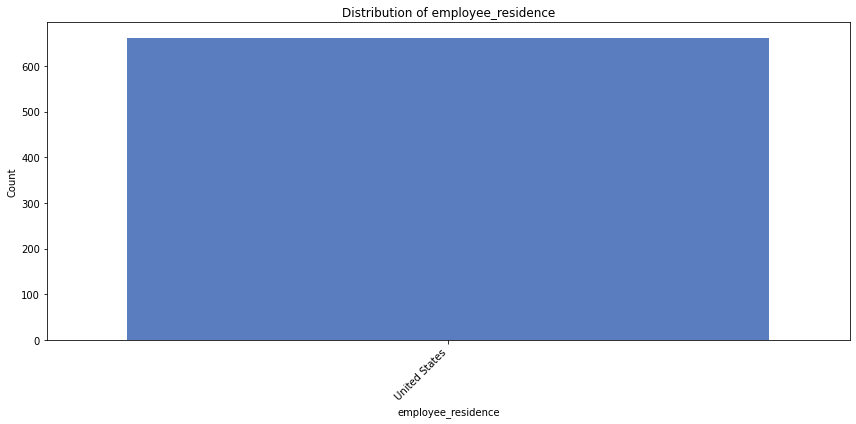

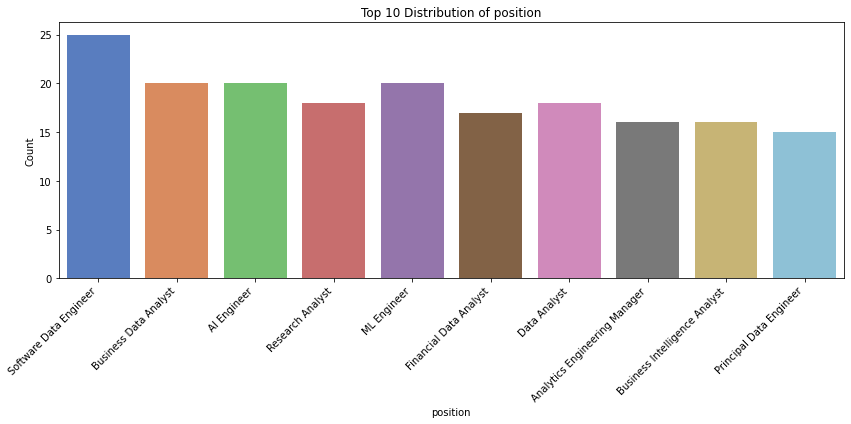

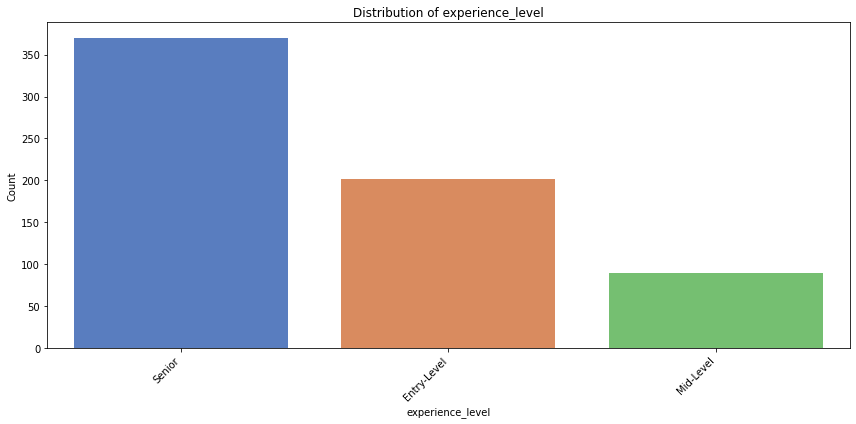

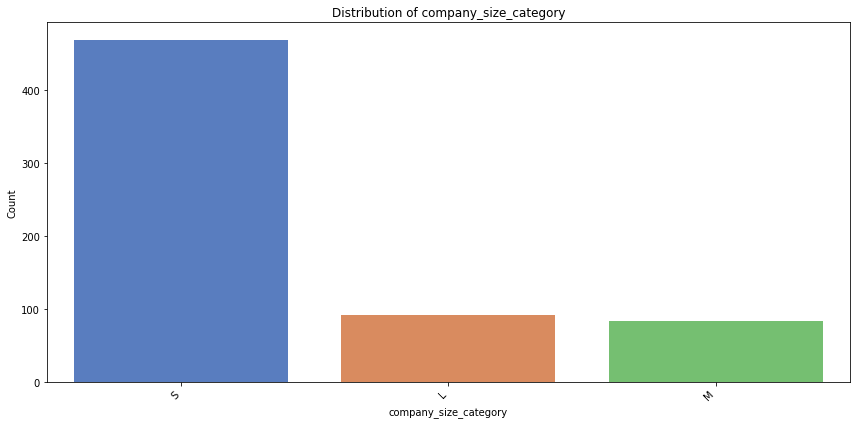

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'filtered_pandas' is your DataFrame
categorical_variables = filtered_pandas[['employee_residence', 'position', 'experience_level', 'company_size_category']]

# Check for missing data and calculate the percentage for each variable
for column in categorical_variables.columns:
    missing_data_percentage = (categorical_variables[column].isnull().sum() / len(categorical_variables[column])) * 100
    print(f"\nMissing Data Percentage for {column}: {missing_data_percentage:.2f}%\n")

    # Check for unusual data (e.g., check unique values and their counts)
    unique_values = categorical_variables[column].unique()
    if len(unique_values) < 10:
        print(f"Unique values for {column}:\n{unique_values}\n")
    else:
        print(f"Number of unique values for {column}: {len(unique_values)}\n")

        # Print the top 5 values and their counts for larger sets
        top_values_counts = categorical_variables[column].value_counts().head()
        print(f"Top 5 values and their counts for {column}:\n{top_values_counts}\n")

# Handle missing data (impute or drop)
# For demonstration purposes, you might want to choose a more appropriate strategy based on your data
categorical_variables.fillna('Unknown', inplace=True)

# Drop rows with 'Unknown' values
categorical_variables = categorical_variables[~categorical_variables.isin(['Unknown']).any(axis=1)].dropna()

# Define a custom color palette
custom_palette = sns.color_palette('muted')  # You can choose any other palette

for column in categorical_variables.columns:
    # Check the number of unique values in the column
    unique_values_count = len(categorical_variables[column].unique())
    
    if unique_values_count > 10:
        # Select the top 10 most common values
        top_values = categorical_variables[column].value_counts().head(10)
        
        # Bar chart for the top 10 values
        plt.figure(figsize=(12, 6))
        sns.countplot(x=column, data=filtered_pandas[filtered_pandas[column].isin(top_values.index)], 
                      order=top_values.index, palette=custom_palette)
        plt.title(f'Top 10 Distribution of {column}')
    else:
        # Bar chart for all values if unique values are less than or equal to 10
        plt.figure(figsize=(12, 6))
        sns.countplot(x=column, data=filtered_pandas, 
                      order=filtered_pandas[column].value_counts().index, palette=custom_palette)
        plt.title(f'Distribution of {column}')
    
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Adjust rotation angle and alignment
    plt.tight_layout()  # Ensure tight layout to prevent clipping
    plt.show()


####Kaggle - LinkedIn Comparison

In [0]:
import pandas as pd

print("Number of rows in data_jobs_df:", data_jobs_df.shape[0])
print("Number of rows in filtered_pandas:", filtered_pandas.shape[0])
print()

distinct_values_count = filtered_pandas['is_original_profile'].value_counts()
print("Distinct values count of 'is_original_profile' column:")
print(distinct_values_count)

# Define the columns of interest
columns_of_interest_data_jobs = ['employee_residence', 'job_title', 'experience_level', 'company_size']
columns_of_interest_filtered_pandas = ['employee_residence', 'position', 'experience_level', 'company_size_category']

# Subset the relevant columns from the datasets
data_jobs_df_subset = data_jobs_df[columns_of_interest_data_jobs]
filtered_pandas_subset = filtered_pandas[columns_of_interest_filtered_pandas]

# Compare the distributions of each column
for column_data_jobs, column_filtered_pandas in zip(columns_of_interest_data_jobs, columns_of_interest_filtered_pandas):
    print(f"\nComparing column: {column_data_jobs} in data_jobs_df vs {column_filtered_pandas} in filtered_pandas\n")
    
    # Calculate value counts for each dataset
    data_jobs_df_counts = data_jobs_df_subset[column_data_jobs].value_counts(normalize=True).sort_index()
    filtered_pandas_counts = filtered_pandas_subset[column_filtered_pandas].value_counts(normalize=True).sort_index()
    
    # Create DataFrame to display the comparison
    comparison_df = pd.DataFrame({
        'data_jobs_df': data_jobs_df_counts,
        'filtered_pandas': filtered_pandas_counts
    })
    
    # Display the comparison DataFrame
    print(comparison_df)


Number of rows in data_jobs_df: 9355
Number of rows in filtered_pandas: 662

Distinct values count of 'is_original_profile' column:
1    662
Name: is_original_profile, dtype: int64

Comparing column: employee_residence in data_jobs_df vs employee_residence in filtered_pandas

                      data_jobs_df  filtered_pandas
Algeria                   0.000107              NaN
American Samoa            0.000107              NaN
Andorra                   0.000107              NaN
Argentina                 0.000962              NaN
Armenia                   0.000214              NaN
...                            ...              ...
United Arab Emirates      0.000321              NaN
United Kingdom            0.047247              NaN
United States             0.864351              1.0
Uzbekistan                0.000321              NaN
Vietnam                   0.000214              NaN

[83 rows x 2 columns]

Comparing column: job_title in data_jobs_df vs position in filtered_pandas



From the comparison between the columns of interest in the datasets used for training (Kaggle, data_jobs_df) and the data used for prediction (LinkedIn, filtered_pandas), we can make several observations:

**Employee Residence:**
The distribution of employee residence between the two datasets seems quite different. While the data_jobs_df dataset covers a wide range of countries, the filtered_pandas dataset appears to be heavily skewed towards the United States, with a proportion of 1.0. This indicates that the predictive model might not generalize well to regions outside the United States, as it was primarily trained on data from that country.

**Job Title:**
The distribution of job titles shows similarities and differences between the two datasets. Some job titles appear in both datasets, such as "AI Developer" and "AI Engineer," with varying frequencies. However, there are also job titles that are present only in one dataset or the other. This suggests that the predictive model might perform well for predicting salaries for job titles that are common across both datasets but may struggle with job titles that are unique to either dataset.

**Experience Level:**
There are differences in the distribution of experience levels between the two datasets. While both datasets include "Entry-Level," "Mid-Level," and "Senior" experience levels, their proportions differ. Additionally, the filtered_pandas dataset includes an "Entry-level" category that is not present in the data_jobs_df dataset. This inconsistency may affect the model's performance, particularly if it was trained to distinguish between specific experience levels.

**Company Size:**
The data_jobs_df dataset provides company size information directly, whereas the filtered_pandas dataset categorizes company size into "Small," "Medium," and "Large" categories. The distribution of company size categories differs slightly between the datasets. This inconsistency in how company size is represented may impact the model's ability to generalize its predictions accurately.

Overall, these observations suggest that the predictive model trained on the Kaggle dataset (data_jobs_df) may not generalize well to the LinkedIn dataset (filtered_pandas) due to differences in the distribution of features between the two datasets. The model's performance may vary depending on the similarity of the data used for training and prediction, especially concerning geographical location, job titles, experience levels, and company size representations. 